# 用FCN来完成语义分割任务


## 1. 什么是语义分割?

语义分割指的是**像素级别**地识别图片,标注出图像中每个像素属于的对象类别.

比如这张经典的图片!

![example1](./images/fcn_example.png)

我们除了识别出自行车和人之外,我们还将他们的边界也进行了描绘.

所以**语义分割可以看做对每一个像素进行分类**


## 2. FCN的简单介绍

为什么要叫 FCN(Fully Convolutional Networks) 呢?

因为在以前的任务中(2015年之前)使用CNN更多地是在卷积层之后会接上若干个全连接层, 将卷积层产生的特征图(feature map)映射成一个固定长度的特征向量（这就丢失了空间信息）。以AlexNet为代表的经典CNN结构适合于图像级的分类和回归任务，因为它们最后都期望得到整个输入图像的一个数值描述（概率），比如AlexNet的ImageNet模型输出一个1000维的向量表示输入图像属于每一类的概率(softmax归一化)。

但是 FCN 不同, FCN对图像进行像素级的分类，从而解决了语义级别的图像分割（semantic segmentation）问题。与经典的CNN在卷积层之后使用全连接层得到固定长度的特征向量进行分类（全联接层＋softmax输出）不同，**FCN可以接受任意尺寸的输入图像，采用反卷积层对最后一个卷积层的feature map进行上采样, 使它恢复到输入图像相同的尺寸**，从而可以对每个像素都产生了一个预测, 同时保留了原始输入图像中的空间信息, 最后在上采样的特征图上进行逐像素分类。


总结一下就是:

**CNN的输入是图像，输出是一个结果，或者说是一个值，一个概率值。**

**FCN提出所追求的是，输入是一张图片是，输出也是一张图片，学习像素到像素的映射 。**

这样的特征刚好符合语义分割任务中的,对像素进行分类.

## 3. FCN的网络架构


![network](./images/FCN_network.png)


整个模型是 end-to-end 的.

具体的流程是: 先**降采样（卷积、池化）**，再**上采样（反卷积）**

降采样是为了更好的获得语义信息(因为不多用几层卷积就没法正确分类)。

但是卷积和池化之后feature map变的很小了，需要还原成原图大小，所以就用上采样（反卷积）的方式把feature map 还原回原图大小。


## 4. FCN中的关键技术

### 4.1 反卷积(Deconvolution) 或者 转置卷积(conv_transpose)

两者其实是等价的,只是称呼上有差异.

详细的介绍就不做了,只给出一张比较直观地动态图

2x2 的原始图像被还原成 4x4 的大小

![conv_transpose](./images/decon.gif)


### 4.2 FCN的前向编码过程

就跟传统的CNN一样, Image(长为H,宽为W) 经过多个 conv 和一个 max-pooling 变成 pool1 feature,长宽变为 1/2 H 和 1/2 W;

pool1 feature 再经过多个 conv 和一个 max-pooling 变成 pool2 feature,长宽变为 1/4 H 和 1/4 W;

pool2 feature 再经过多个 conv 和一个 max-pooling 变成 pool3 feature,长宽变为 1/8 H 和 1/8 W;

...


一直到 pool5 feature, 它的长宽为 1/32 H 和 1/32 W;


### 4.3 FCN的反向编码过程




![conv_transpose](./images/FCNdecon.png)

对于 FCN-32s 而言,直接对 pool5 feature 进行32倍上采样获得 32 x upsampled feature, 再对 32 x upsampled feature 每个点做 softmax prediction 获得 32 x upsampled feature prediction (也就是分割图)

对于 FCN-16s 而言,首先对 pool5 feature 进行2倍上采样获得 2 x upsampled feature, 再把 pool4 feature 和 2 x upsampled feature 逐点相加,然后对相加的 feature 进行16倍上采样,并做 softmax prediction 获得 16 x upsampled feature prediction

对于 FCN-8s 而言,首先进行 pool4 feature 和 2 x upsampled feature 逐点相加,然后又进行 pool3 feature 和 2 x upsampled feature 逐点相加,即进行更多次的特征融合,具体形式如 16s.



### 4.4 FCN 的总结

1. 将寻常CNN最后几层的全连接层替换成卷几层,完成了针对像素的分类

2. 阐述了CNN如何进行 end-to-end 的训练

3. 输入图片的尺寸不再做限制,任意大小的输入图片都可以完成像素级别的分类(语义分割任务).

## 5. 数据下载


[PASCAL VOC2012数据集](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar)


下载之后,解压文件夹,然后修改 voc_root 的值,比如,我解压到了上级目录的 data 文件夹中,那么我的 

```
voc_root = '../data/VOCdevkit/VOC2012'
```

In [1]:
# 导入需要的包
import os
import time
import torch
import warnings
import numpy as np
from torch import nn
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler
import torchvision.transforms as tfs
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings("ignore")

In [2]:
# 数据路径,如果不一致,请自行修改
voc_root = '../data/VOCdevkit/VOC2012'
def read_images(root=voc_root, train=True):
    txt_fname = root + '/ImageSets/Segmentation/' + ('train.txt' if train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    data = [os.path.join(root, 'JPEGImages', i+'.jpg') for i in images]
    label = [os.path.join(root, 'SegmentationClass', i+'.png') for i in images]
    return data, label

In [3]:
#等比例压缩图片
def scale_high(img, target_high):
    ow, oh = img.size
    if (ow == target_high):
        return img
    h = target_high
    w = int(target_high * ow / oh)
    return img.resize((w, h), Image.BICUBIC)

#中心裁剪
def random_crop(data, label, crop_size):
    transforms = tfs.CenterCrop(crop_size)
    data = transforms(data)
    label = transforms(label)
    return data, label

In [4]:
classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']

colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]

len(classes), len(colormap)

(21, 21)

In [5]:
# 每个像素点有 0 ~ 255 的选择，RGB 三个通道
cm2lbl = np.zeros(256**3) 
for i,cm in enumerate(colormap):
    # 建立索引
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]] = i 

def image2label(img):
    data = np.array(img, dtype='int32')
    idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
    # 根据索引得到 label 矩阵
    return np.array(cm2lbl[idx], dtype='int64') 

In [6]:
def img_transforms(img, label, crop_size):
    img, label = random_crop(img, label, crop_size)
    img = scale_high(img,int(img.size[1]/2))
    label = scale_high(label,int(label.size[1]/2))
    img_tfs = tfs.Compose([      
        tfs.ToTensor(),
        tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img = img_tfs(img)
    label = image2label(label)
    label = torch.from_numpy(label)
    return img, label

#制作数据集
class VOCSegDataset(Dataset):
    def __init__(self, train, crop_size, transforms):
        self.crop_size = crop_size
        self.transforms = transforms
        self.data_list, self.label_list = read_images(train=train)
        print('Read ' + str(len(self.data_list)) + ' images')
        
        
    def __getitem__(self, idx):
        img = self.data_list[idx]
        label = self.label_list[idx]
        img = Image.open(img)
        label = Image.open(label).convert('RGB')
        img, label = self.transforms(img, label, self.crop_size)
        return img, label
    
    def __len__(self):
        return len(self.data_list)

In [7]:
# 实例化数据集
batch_size = 8
input_shape = (512, 512)
train_data = VOCSegDataset(True, input_shape, img_transforms)
testdata = VOCSegDataset(False, input_shape, img_transforms)
trainloader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
testloader = DataLoader(testdata, batch_size = batch_size, shuffle=True)

Read 1464 images
Read 1449 images


In [8]:
#初始化权值
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

In [9]:
#FCN网络结构的定义
n_class = len(classes)
class FCN(nn.Module):
    def __init__(self, n_class=21):
        super(FCN, self).__init__()
        # conv1
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2

        # conv2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/8

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/16

        # conv5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/32

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.score_pool3 = nn.Conv2d(256, n_class, 1)
        self.score_pool4 = nn.Conv2d(512, n_class, 1)

        self.upscore2 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
        self.upscore8 = nn.ConvTranspose2d(
            n_class, n_class, 16, stride=8, bias=False)
        self.upscore_pool4 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        h = x
        h = self.relu1_1(self.conv1_1(h))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)
        pool3 = h  # 1/8

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)
        pool4 = h  # 1/16

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        h = self.score_fr(h)
        h = self.upscore2(h)
        upscore2 = h  # 1/16

        h = self.score_pool4(pool4)
        h = h[:, :, 5:5 + upscore2.size()[2], 5:5 + upscore2.size()[3]]
        score_pool4c = h  # 1/16

        h = upscore2 + score_pool4c  # 1/16
        h = self.upscore_pool4(h)
        upscore_pool4 = h  # 1/8

        h = self.score_pool3(pool3)
        h = h[:, :,
              9:9 + upscore_pool4.size()[2],
              9:9 + upscore_pool4.size()[3]]
        score_pool3c = h  # 1/8

        h = upscore_pool4 + score_pool3c  # 1/8

        h = self.upscore8(h)
        h = h[:, :, 31:31 + x.size()[2], 31:31 + x.size()[3]].contiguous()

        return h

In [10]:
#模型实例化 
model = FCN(n_class)
use_gpu = False
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()

In [11]:
model

FCN(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
  (relu1_1): ReLU(inplace)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU(inplace)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU(inplace)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU(inplace)
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU(inplace)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

In [12]:
num_epoches = 100 # 训练次数
learning_rate = 0.001
weight_decay=1e-4
criterion = nn.NLLLoss2d()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [13]:
# IoU的值定义：(候选区域)Region Proposal与（标记区域）Ground Truth的窗口的交集比并集的比值，如果IoU低于0.5，
# 那么相当于目标还是没有检测到
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist

def label_accuracy_score(label_trues, label_preds, n_class):
    """Returns accuracy score evaluation result.
      - overall accuracy
      - mean accuracy
      - mean IU
      - fwavacc
    """
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc

In [14]:
#学习率的优化
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=30):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.5**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [15]:
#模型的训练与测试
def train_test(optimizer):
    #训练
    epochacc_y=[]
    wrong_all=[]
    testacc_y=[]
    epoch_y = []
    for epoch in range(num_epoches):
        print ('- - - - - epoch',epoch+1,'- - - - - - - -')
        train_acc_cls = 0
        epoch_mean_IoU = 0
        train_fwavacc = 0
        
        batch_idx_sum = 0 
        minibatch_loss=0
        epoch_loss_sum=0
        epoch_acc=0
        
        optimizer = exp_lr_scheduler(optimizer, epoch)
        
        for batch_idx, data in enumerate(trainloader , 1):
            
            batch_idx_sum += data[0].size()[0]
            
            if use_gpu:
                im = Variable(data[0]).cuda()
                label = Variable(data[1]).cuda()
            else:
                im = Variable(data[0])
                label = Variable(data[1])
            
            out = model(im)

            out = F.log_softmax(out) 
        
            minibatch_loss = criterion(out, label)
            
            optimizer.zero_grad()
            
            minibatch_loss.backward()
            
            optimizer.step()
            
            # 该列表存放每一个batch的loss值
            
            epoch_loss_sum += minibatch_loss.data[0]

            label_pred = out.max(dim=1)[1].data.cpu().numpy()
            
            label_true = label.data.cpu().numpy()
            
            for lbt, lbp in zip(label_true, label_pred):
                acc, acc_cls, mean_iu, fwavacc = label_accuracy_score(lbt, lbp, n_class)
                epoch_acc += acc
                train_acc_cls += acc_cls
                epoch_mean_IoU += mean_iu
                train_fwavacc += fwavacc
                        
            if batch_idx % 20 == 0 :
                print("Train Epoch: {} [{}/{} ({:.0f}%)] ,Loss: {:.6f} ,Accuracy:{:.2f}%, Train Mean IoU:{:.5f}".format(
                    epoch+1,
                    batch_idx_sum,
                    len(train_data),
                    100. * batch_idx_sum / len(train_data),
                    minibatch_loss.data[0],
                    100.*epoch_acc / batch_idx_sum,    
                    epoch_mean_IoU / batch_idx_sum     
                    ))
                
        epoch_loss_average = epoch_loss_sum/len(trainloader)

        epoch_y.append(epoch_loss_average)
        
        epoch_acc_average=epoch_acc/len(train_data)

        epochacc_y.append(epoch_acc_average)
    #############################################################
    #测试
        print ('- - - - - test stage- - - - - - - -')
        model.eval()
        step_sum = 0
        test_loss = 0
        test_acc = 0
        test_acc_cls = 0
        test_mean_IoU = 0
        test_fwavacc = 0
        for step, data in enumerate(testloader , 1):
            
            step_sum += data[0].size()[0]
            
            if use_gpu:
                im = Variable(data[0], volatile=True).cuda()
                label = Variable(data[1], volatile=True).cuda()
            else:
                im = Variable(data[0])
                label = Variable(data[1])
            
            out = model(im)
            out = F.log_softmax(out)
            test_loss = criterion(out, label)

            label_pred = out.max(dim=1)[1].data.cpu().numpy()
            label_true = label.data.cpu().numpy()
            
            for lbt, lbp in zip(label_true, label_pred):
                acc, acc_cls, mean_IoU, fwavacc = label_accuracy_score(lbt, lbp, n_class)
                test_acc += acc
                test_acc_cls += acc_cls
                test_mean_IoU += mean_IoU
                test_fwavacc += fwavacc
        
        testacc=test_acc/len(testloader)
        
        test_mean_IoU = test_mean_IoU/len(testloader)
        
        testacc_y.append(testacc)
        
        print("Test_accuracy: {:.2f}% , Test Mean IoU: {:.5f} ".format(testacc, test_mean_IoU))
    return epoch_y, epochacc_y ,testacc_y

In [16]:
#模型评估
train_start = time.time()
epoch_y, epochacc_y ,testacc_y = train_test(optimizer)
train_stop = time.time()
train_total = train_stop - train_start
print('Training complete in {:.0f}m {:.0f}s'.format(train_total // 60, train_total % 60))

- - - - - epoch 1 - - - - - - - -
LR is set to 0.001
Train Epoch: 1 [160/1464 (11%)] ,Loss: 2.402696 ,Accuracy:83.67%, Train Mean IoU:0.36136
Train Epoch: 1 [320/1464 (22%)] ,Loss: 0.905181 ,Accuracy:84.18%, Train Mean IoU:0.36267
Train Epoch: 1 [480/1464 (33%)] ,Loss: 0.856753 ,Accuracy:84.70%, Train Mean IoU:0.36606
Train Epoch: 1 [640/1464 (44%)] ,Loss: 1.302709 ,Accuracy:84.56%, Train Mean IoU:0.36617
Train Epoch: 1 [800/1464 (55%)] ,Loss: 0.969163 ,Accuracy:84.77%, Train Mean IoU:0.36792
Train Epoch: 1 [960/1464 (66%)] ,Loss: 0.678338 ,Accuracy:84.86%, Train Mean IoU:0.36897
Train Epoch: 1 [1120/1464 (77%)] ,Loss: 0.745183 ,Accuracy:84.85%, Train Mean IoU:0.36857
Train Epoch: 1 [1280/1464 (87%)] ,Loss: 0.958804 ,Accuracy:84.87%, Train Mean IoU:0.36882
Train Epoch: 1 [1440/1464 (98%)] ,Loss: 0.630206 ,Accuracy:84.89%, Train Mean IoU:0.36900
- - - - - test stage- - - - - - - -
Test_accuracy: 6.76% , Test Mean IoU: 2.94190 
- - - - - epoch 2 - - - - - - - -
Train Epoch: 2 [160/1464 (

- - - - - test stage- - - - - - - -
Test_accuracy: 6.76% , Test Mean IoU: 2.94190 
- - - - - epoch 10 - - - - - - - -
Train Epoch: 10 [160/1464 (11%)] ,Loss: 0.834782 ,Accuracy:85.24%, Train Mean IoU:0.36799
Train Epoch: 10 [320/1464 (22%)] ,Loss: 0.776323 ,Accuracy:84.58%, Train Mean IoU:0.36405
Train Epoch: 10 [480/1464 (33%)] ,Loss: 1.175837 ,Accuracy:84.94%, Train Mean IoU:0.36709
Train Epoch: 10 [640/1464 (44%)] ,Loss: 0.743804 ,Accuracy:84.42%, Train Mean IoU:0.36539
Train Epoch: 10 [800/1464 (55%)] ,Loss: 0.849884 ,Accuracy:84.78%, Train Mean IoU:0.36730
Train Epoch: 10 [960/1464 (66%)] ,Loss: 0.607467 ,Accuracy:84.85%, Train Mean IoU:0.36829
Train Epoch: 10 [1120/1464 (77%)] ,Loss: 0.420894 ,Accuracy:84.89%, Train Mean IoU:0.36887
Train Epoch: 10 [1280/1464 (87%)] ,Loss: 0.675807 ,Accuracy:84.98%, Train Mean IoU:0.36923
Train Epoch: 10 [1440/1464 (98%)] ,Loss: 0.834539 ,Accuracy:84.86%, Train Mean IoU:0.36828
- - - - - test stage- - - - - - - -
Test_accuracy: 6.76% , Test Mean 

Train Epoch: 18 [1280/1464 (87%)] ,Loss: 0.926769 ,Accuracy:84.94%, Train Mean IoU:0.36976
Train Epoch: 18 [1440/1464 (98%)] ,Loss: 0.960551 ,Accuracy:84.87%, Train Mean IoU:0.36849
- - - - - test stage- - - - - - - -
Test_accuracy: 6.76% , Test Mean IoU: 2.94190 
- - - - - epoch 19 - - - - - - - -
Train Epoch: 19 [160/1464 (11%)] ,Loss: 0.852322 ,Accuracy:86.32%, Train Mean IoU:0.38413
Train Epoch: 19 [320/1464 (22%)] ,Loss: 0.658716 ,Accuracy:84.84%, Train Mean IoU:0.36890
Train Epoch: 19 [480/1464 (33%)] ,Loss: 0.626228 ,Accuracy:85.28%, Train Mean IoU:0.36765
Train Epoch: 19 [640/1464 (44%)] ,Loss: 0.751829 ,Accuracy:85.28%, Train Mean IoU:0.36994
Train Epoch: 19 [800/1464 (55%)] ,Loss: 0.751632 ,Accuracy:85.07%, Train Mean IoU:0.36963
Train Epoch: 19 [960/1464 (66%)] ,Loss: 0.639441 ,Accuracy:84.99%, Train Mean IoU:0.37047
Train Epoch: 19 [1120/1464 (77%)] ,Loss: 0.732789 ,Accuracy:84.92%, Train Mean IoU:0.36911
Train Epoch: 19 [1280/1464 (87%)] ,Loss: 0.920148 ,Accuracy:84.68%, T

Train Epoch: 27 [960/1464 (66%)] ,Loss: 1.152203 ,Accuracy:84.95%, Train Mean IoU:0.36969
Train Epoch: 27 [1120/1464 (77%)] ,Loss: 0.899088 ,Accuracy:85.09%, Train Mean IoU:0.36878
Train Epoch: 27 [1280/1464 (87%)] ,Loss: 0.561034 ,Accuracy:85.02%, Train Mean IoU:0.36848
Train Epoch: 27 [1440/1464 (98%)] ,Loss: 0.952492 ,Accuracy:84.95%, Train Mean IoU:0.36892
- - - - - test stage- - - - - - - -
Test_accuracy: 6.76% , Test Mean IoU: 2.94190 
- - - - - epoch 28 - - - - - - - -
Train Epoch: 28 [160/1464 (11%)] ,Loss: 0.649826 ,Accuracy:86.42%, Train Mean IoU:0.36474
Train Epoch: 28 [320/1464 (22%)] ,Loss: 1.327476 ,Accuracy:85.75%, Train Mean IoU:0.36953
Train Epoch: 28 [480/1464 (33%)] ,Loss: 0.759570 ,Accuracy:85.43%, Train Mean IoU:0.37165
Train Epoch: 28 [640/1464 (44%)] ,Loss: 0.743222 ,Accuracy:85.38%, Train Mean IoU:0.37024
Train Epoch: 28 [800/1464 (55%)] ,Loss: 0.899942 ,Accuracy:85.12%, Train Mean IoU:0.36974
Train Epoch: 28 [960/1464 (66%)] ,Loss: 0.932075 ,Accuracy:85.04%, Tr

Train Epoch: 36 [640/1464 (44%)] ,Loss: 0.855983 ,Accuracy:85.01%, Train Mean IoU:0.37078
Train Epoch: 36 [800/1464 (55%)] ,Loss: 0.822277 ,Accuracy:85.06%, Train Mean IoU:0.36814
Train Epoch: 36 [960/1464 (66%)] ,Loss: 1.133113 ,Accuracy:84.79%, Train Mean IoU:0.36613
Train Epoch: 36 [1120/1464 (77%)] ,Loss: 0.820957 ,Accuracy:84.79%, Train Mean IoU:0.36646
Train Epoch: 36 [1280/1464 (87%)] ,Loss: 0.864756 ,Accuracy:84.65%, Train Mean IoU:0.36625
Train Epoch: 36 [1440/1464 (98%)] ,Loss: 1.002903 ,Accuracy:84.83%, Train Mean IoU:0.36743
- - - - - test stage- - - - - - - -
Test_accuracy: 6.76% , Test Mean IoU: 2.94190 
- - - - - epoch 37 - - - - - - - -
Train Epoch: 37 [160/1464 (11%)] ,Loss: 0.783950 ,Accuracy:86.31%, Train Mean IoU:0.38502
Train Epoch: 37 [320/1464 (22%)] ,Loss: 0.644767 ,Accuracy:85.13%, Train Mean IoU:0.37131
Train Epoch: 37 [480/1464 (33%)] ,Loss: 0.715990 ,Accuracy:85.28%, Train Mean IoU:0.37014
Train Epoch: 37 [640/1464 (44%)] ,Loss: 0.880177 ,Accuracy:84.79%, Tr

Train Epoch: 45 [320/1464 (22%)] ,Loss: 0.591590 ,Accuracy:84.27%, Train Mean IoU:0.36981
Train Epoch: 45 [480/1464 (33%)] ,Loss: 0.571124 ,Accuracy:84.74%, Train Mean IoU:0.37448
Train Epoch: 45 [640/1464 (44%)] ,Loss: 0.484832 ,Accuracy:84.53%, Train Mean IoU:0.37286
Train Epoch: 45 [800/1464 (55%)] ,Loss: 0.640872 ,Accuracy:84.82%, Train Mean IoU:0.37398
Train Epoch: 45 [960/1464 (66%)] ,Loss: 0.931313 ,Accuracy:84.74%, Train Mean IoU:0.37205
Train Epoch: 45 [1120/1464 (77%)] ,Loss: 0.817692 ,Accuracy:84.64%, Train Mean IoU:0.36928
Train Epoch: 45 [1280/1464 (87%)] ,Loss: 0.717358 ,Accuracy:84.68%, Train Mean IoU:0.36775
Train Epoch: 45 [1440/1464 (98%)] ,Loss: 0.613119 ,Accuracy:84.88%, Train Mean IoU:0.36862
- - - - - test stage- - - - - - - -
Test_accuracy: 6.76% , Test Mean IoU: 2.94190 
- - - - - epoch 46 - - - - - - - -
Train Epoch: 46 [160/1464 (11%)] ,Loss: 0.510176 ,Accuracy:84.22%, Train Mean IoU:0.36795
Train Epoch: 46 [320/1464 (22%)] ,Loss: 1.100514 ,Accuracy:84.96%, Tr

Test_accuracy: 6.76% , Test Mean IoU: 2.94190 
- - - - - epoch 54 - - - - - - - -
Train Epoch: 54 [160/1464 (11%)] ,Loss: 0.937330 ,Accuracy:84.95%, Train Mean IoU:0.36198
Train Epoch: 54 [320/1464 (22%)] ,Loss: 0.960804 ,Accuracy:84.85%, Train Mean IoU:0.36304
Train Epoch: 54 [480/1464 (33%)] ,Loss: 0.725337 ,Accuracy:85.01%, Train Mean IoU:0.36521
Train Epoch: 54 [640/1464 (44%)] ,Loss: 0.795570 ,Accuracy:85.49%, Train Mean IoU:0.37101
Train Epoch: 54 [800/1464 (55%)] ,Loss: 0.575039 ,Accuracy:85.32%, Train Mean IoU:0.37088
Train Epoch: 54 [960/1464 (66%)] ,Loss: 1.034183 ,Accuracy:85.22%, Train Mean IoU:0.36990
Train Epoch: 54 [1120/1464 (77%)] ,Loss: 0.645227 ,Accuracy:85.17%, Train Mean IoU:0.37016
Train Epoch: 54 [1280/1464 (87%)] ,Loss: 0.712551 ,Accuracy:85.01%, Train Mean IoU:0.36809
Train Epoch: 54 [1440/1464 (98%)] ,Loss: 0.789541 ,Accuracy:84.86%, Train Mean IoU:0.36853
- - - - - test stage- - - - - - - -
Test_accuracy: 6.76% , Test Mean IoU: 2.94190 
- - - - - epoch 55 - -

Train Epoch: 62 [1440/1464 (98%)] ,Loss: 0.926895 ,Accuracy:84.92%, Train Mean IoU:0.36888
- - - - - test stage- - - - - - - -
Test_accuracy: 6.76% , Test Mean IoU: 2.94190 
- - - - - epoch 63 - - - - - - - -
Train Epoch: 63 [160/1464 (11%)] ,Loss: 0.694627 ,Accuracy:86.57%, Train Mean IoU:0.37061
Train Epoch: 63 [320/1464 (22%)] ,Loss: 0.869257 ,Accuracy:85.99%, Train Mean IoU:0.37407
Train Epoch: 63 [480/1464 (33%)] ,Loss: 0.545929 ,Accuracy:85.79%, Train Mean IoU:0.37104
Train Epoch: 63 [640/1464 (44%)] ,Loss: 0.678240 ,Accuracy:85.65%, Train Mean IoU:0.37179
Train Epoch: 63 [800/1464 (55%)] ,Loss: 0.716967 ,Accuracy:85.82%, Train Mean IoU:0.36970
Train Epoch: 63 [960/1464 (66%)] ,Loss: 0.716922 ,Accuracy:85.45%, Train Mean IoU:0.36931
Train Epoch: 63 [1120/1464 (77%)] ,Loss: 0.821818 ,Accuracy:85.33%, Train Mean IoU:0.37091
Train Epoch: 63 [1280/1464 (87%)] ,Loss: 0.706706 ,Accuracy:85.12%, Train Mean IoU:0.36993
Train Epoch: 63 [1440/1464 (98%)] ,Loss: 0.933839 ,Accuracy:84.91%, T

Train Epoch: 71 [1120/1464 (77%)] ,Loss: 0.917131 ,Accuracy:85.09%, Train Mean IoU:0.36987
Train Epoch: 71 [1280/1464 (87%)] ,Loss: 0.886291 ,Accuracy:85.01%, Train Mean IoU:0.36922
Train Epoch: 71 [1440/1464 (98%)] ,Loss: 0.717558 ,Accuracy:84.86%, Train Mean IoU:0.36878
- - - - - test stage- - - - - - - -
Test_accuracy: 6.76% , Test Mean IoU: 2.94190 
- - - - - epoch 72 - - - - - - - -
Train Epoch: 72 [160/1464 (11%)] ,Loss: 0.634068 ,Accuracy:85.42%, Train Mean IoU:0.38143
Train Epoch: 72 [320/1464 (22%)] ,Loss: 0.867378 ,Accuracy:85.28%, Train Mean IoU:0.37265
Train Epoch: 72 [480/1464 (33%)] ,Loss: 0.984190 ,Accuracy:85.69%, Train Mean IoU:0.37546
Train Epoch: 72 [640/1464 (44%)] ,Loss: 0.676903 ,Accuracy:85.71%, Train Mean IoU:0.37421
Train Epoch: 72 [800/1464 (55%)] ,Loss: 0.820944 ,Accuracy:85.62%, Train Mean IoU:0.37103
Train Epoch: 72 [960/1464 (66%)] ,Loss: 0.677773 ,Accuracy:85.49%, Train Mean IoU:0.37048
Train Epoch: 72 [1120/1464 (77%)] ,Loss: 0.900896 ,Accuracy:85.21%, T

Train Epoch: 80 [800/1464 (55%)] ,Loss: 0.793750 ,Accuracy:85.16%, Train Mean IoU:0.36849
Train Epoch: 80 [960/1464 (66%)] ,Loss: 0.749034 ,Accuracy:85.06%, Train Mean IoU:0.36867
Train Epoch: 80 [1120/1464 (77%)] ,Loss: 0.679658 ,Accuracy:85.18%, Train Mean IoU:0.37082
Train Epoch: 80 [1280/1464 (87%)] ,Loss: 0.657960 ,Accuracy:85.11%, Train Mean IoU:0.37059
Train Epoch: 80 [1440/1464 (98%)] ,Loss: 1.241357 ,Accuracy:84.89%, Train Mean IoU:0.36867
- - - - - test stage- - - - - - - -
Test_accuracy: 6.76% , Test Mean IoU: 2.94190 
- - - - - epoch 81 - - - - - - - -
Train Epoch: 81 [160/1464 (11%)] ,Loss: 0.732551 ,Accuracy:84.60%, Train Mean IoU:0.36179
Train Epoch: 81 [320/1464 (22%)] ,Loss: 0.571267 ,Accuracy:84.95%, Train Mean IoU:0.36495
Train Epoch: 81 [480/1464 (33%)] ,Loss: 0.777130 ,Accuracy:84.95%, Train Mean IoU:0.36855
Train Epoch: 81 [640/1464 (44%)] ,Loss: 0.815974 ,Accuracy:84.94%, Train Mean IoU:0.36800
Train Epoch: 81 [800/1464 (55%)] ,Loss: 1.095025 ,Accuracy:84.69%, Tr

Train Epoch: 89 [480/1464 (33%)] ,Loss: 0.659723 ,Accuracy:84.34%, Train Mean IoU:0.36157
Train Epoch: 89 [640/1464 (44%)] ,Loss: 0.622848 ,Accuracy:84.42%, Train Mean IoU:0.36515
Train Epoch: 89 [800/1464 (55%)] ,Loss: 0.901543 ,Accuracy:84.65%, Train Mean IoU:0.36674
Train Epoch: 89 [960/1464 (66%)] ,Loss: 1.276019 ,Accuracy:84.77%, Train Mean IoU:0.36703
Train Epoch: 89 [1120/1464 (77%)] ,Loss: 0.803418 ,Accuracy:84.72%, Train Mean IoU:0.36836
Train Epoch: 89 [1280/1464 (87%)] ,Loss: 0.547696 ,Accuracy:84.73%, Train Mean IoU:0.36663
Train Epoch: 89 [1440/1464 (98%)] ,Loss: 0.670748 ,Accuracy:84.81%, Train Mean IoU:0.36810
- - - - - test stage- - - - - - - -
Test_accuracy: 6.76% , Test Mean IoU: 2.94190 
- - - - - epoch 90 - - - - - - - -
Train Epoch: 90 [160/1464 (11%)] ,Loss: 0.575398 ,Accuracy:83.96%, Train Mean IoU:0.36031
Train Epoch: 90 [320/1464 (22%)] ,Loss: 1.012705 ,Accuracy:84.35%, Train Mean IoU:0.36231
Train Epoch: 90 [480/1464 (33%)] ,Loss: 0.511496 ,Accuracy:84.28%, Tr

Train Epoch: 98 [160/1464 (11%)] ,Loss: 0.408519 ,Accuracy:85.65%, Train Mean IoU:0.36746
Train Epoch: 98 [320/1464 (22%)] ,Loss: 0.726540 ,Accuracy:83.99%, Train Mean IoU:0.36116
Train Epoch: 98 [480/1464 (33%)] ,Loss: 0.613069 ,Accuracy:84.45%, Train Mean IoU:0.36503
Train Epoch: 98 [640/1464 (44%)] ,Loss: 0.693093 ,Accuracy:85.19%, Train Mean IoU:0.36771
Train Epoch: 98 [800/1464 (55%)] ,Loss: 1.146097 ,Accuracy:85.03%, Train Mean IoU:0.36580
Train Epoch: 98 [960/1464 (66%)] ,Loss: 0.757297 ,Accuracy:85.12%, Train Mean IoU:0.36904
Train Epoch: 98 [1120/1464 (77%)] ,Loss: 0.815357 ,Accuracy:84.94%, Train Mean IoU:0.37004
Train Epoch: 98 [1280/1464 (87%)] ,Loss: 0.968653 ,Accuracy:84.86%, Train Mean IoU:0.36800
Train Epoch: 98 [1440/1464 (98%)] ,Loss: 0.946159 ,Accuracy:84.83%, Train Mean IoU:0.36842
- - - - - test stage- - - - - - - -
Test_accuracy: 6.76% , Test Mean IoU: 2.94190 
- - - - - epoch 99 - - - - - - - -
Train Epoch: 99 [160/1464 (11%)] ,Loss: 0.683885 ,Accuracy:85.59%, Tr

In [17]:
#模型保存
torch.save(model.state_dict(), './FCN_params.pkl')  

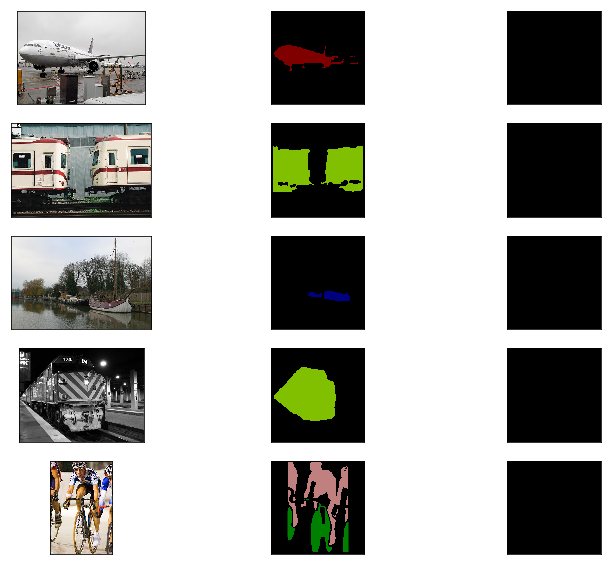

In [20]:
# 预测结果可视化处理
cm = np.array(colormap).astype('uint8')
def predict(im, label): # 预测结果
    im = Variable(im.unsqueeze(0))
    if use_gpu:
        im = im.cuda()
    out = model(im)
    pred = out.max(1)[1].squeeze().cpu().data.numpy()
    pred = cm[pred]
    return pred, cm[label.numpy()]
_, figs = plt.subplots(5, 3, figsize=(12, 10))
for i in range(5):
    test_data, test_label = testdata[i]
    pred, label = predict(test_data, test_label)
    figs[i, 0].imshow(Image.open(testdata.data_list[i]))
    figs[i, 0].axes.get_xaxis().set_visible(False)
    figs[i, 0].axes.get_yaxis().set_visible(False)
    figs[i, 1].imshow(label)
    figs[i, 1].axes.get_xaxis().set_visible(False)
    figs[i, 1].axes.get_yaxis().set_visible(False)
    figs[i, 2].imshow(pred)
    figs[i, 2].axes.get_xaxis().set_visible(False)
    figs[i, 2].axes.get_yaxis().set_visible(False)

结论:似乎有一丢丢用啊,尝试多几次训练可以观察效果会不会更好